In [18]:
import sqlite3 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp_stats

In [6]:
DB_FN_FULL = "../db/massbank__only_normalized_scores.sqlite"
DB_URI_FULL = "file:" + DB_FN_FULL + "?mode=ro"
DB_CONN_FULL_RO = sqlite3.connect(DB_URI_FULL, uri=True)

METLIN_DATA = pd.read_csv("metlin_data.tsv", sep="\t")

In [8]:
for idx, (ds, ) in enumerate(DB_CONN_FULL_RO.execute(
    "SELECT distinct(dataset) FROM scored_spectra_meta "
    "   INNER JOIN datasets d on scored_spectra_meta.dataset = d.name"
    "   WHERE column_type IS 'RP'"
)):
    # Fetch accessions associated with the current dataset
    acc, inchikeys, inchikeys1 = zip(*DB_CONN_FULL_RO.execute(
        "SELECT accession, inchikey, inchikey1 FROM scored_spectra_meta"
        "   INNER JOIN datasets d ON scored_spectra_meta.dataset = d.name"
        "   INNER JOIN molecules m ON scored_spectra_meta.molecule = m.cid"
        "   WHERE retention_time >= 3 * column_dead_time_min"  # Filter non-interacting molecules      
        "     AND dataset IS ?", (ds, )
    ).fetchall())
    
    n_acc = len(acc)
    
    if n_acc <= 75:
        print(idx, ds, 1, n_acc)
    elif n_acc <= 250:
        print(idx, ds, 15, n_acc)
    else:
        print(idx, ds, n_acc // 50, n_acc)

0 AC_003 15 179
6
1 AU_003 15 90
17
2 AU_002 14 746
44
3 BML_001 15 250
37
4 CE_001 1 39
3
5 EA_003 6 307
22
6 EA_002 6 301
22
7 EQ_006 15 211
20
8 EQ_004 15 181
19
9 ET_002 1 50
3
10 KW_000 1 55
1
11 LU_001 11 567
28
12 NA_003 15 97
17
13 PR_002 18 911
47
14 RP_001 15 150
4
15 SM_001 7 357
25
16 UF_003 15 140
10
17 UF_002 15 149
11
18 AU_000 15 168
11
19 BML_000 15 170
23
20 BS_000 15 216
6
21 EA_000 15 141
8
22 EA_001 15 147
8
23 EQ_003 15 92
11
24 EQ_001 15 86
13
25 LQB_000 6 301
0
26 LU_000 7 358
19
27 PR_000 14 709
26
28 RP_000 1 69
2
29 SM_000 15 161
12
30 UT_000 6 318
0


## Overlap of MassBank with the METLIN Retention Time Dataset

In [64]:
df_overlap = []

for idx, (ds, ) in enumerate(DB_CONN_FULL_RO.execute(
    "SELECT distinct(dataset) FROM scored_spectra_meta "
    "   INNER JOIN datasets d on scored_spectra_meta.dataset = d.name"
    "   WHERE column_type IS 'RP'"
)):
    # Fetch accessions associated with the current dataset
    df_ds = pd.read_sql(
        "SELECT accession, cid, inchikey, inchikey1, retention_time as rt FROM scored_spectra_meta"
        "   INNER JOIN datasets d ON scored_spectra_meta.dataset = d.name"
        "   INNER JOIN molecules m ON scored_spectra_meta.molecule = m.cid"
        "   WHERE retention_time >= 3 * column_dead_time_min"  # Filter non-interacting molecules      
        "     AND dataset IS '%s'" % ds, 
        DB_CONN_FULL_RO
    )
    
    #df_ds = pd.read_sql(
    #    "SELECT accession, cid, inchikey, inchikey1, retention_time as rt FROM spectra_meta"
    #    "   INNER JOIN datasets d ON spectra_meta.dataset = d.name"
    #    "   INNER JOIN molecules m ON spectra_meta.molecule = m.cid"
    #    "   INNER JOIN spectra_rts sr ON spectra_meta.accession = sr.spectrum"
    #    "   WHERE retention_time >= 3 * column_dead_time_min"  # Filter non-interacting molecules      
    #    "     AND dataset IS '%s'" % ds, 
    #    DB_CONN_FULL_RO
    #)
    
    print(ds, len(df_ds))
    
    df_merge = pd.merge(METLIN_DATA, df_ds, on="inchikey1")
    
    df_overlap.append([
        ds,
        len(df_merge), 
        df_merge["rt_x"].tolist(), 
        df_merge["rt_y"].tolist()
    ])
    

df_overlap = pd.DataFrame(df_overlap, columns=["dataset", "n_overlap_with_metlin", "metlin_rt", "massbank_rt"])

AC_003 179
AU_003 90
AU_002 746
BML_001 250
CE_001 39
EA_003 307
EA_002 301
EQ_006 211
EQ_004 181
ET_002 50
KW_000 55
LU_001 567
NA_003 97
PR_002 911
RP_001 150
SM_001 357
UF_003 140
UF_002 149
AU_000 168
BML_000 170
BS_000 216
EA_000 141
EA_001 147
EQ_003 92
EQ_001 86
LQB_000 301
LU_000 358
PR_000 709
RP_000 69
SM_000 161
UT_000 318


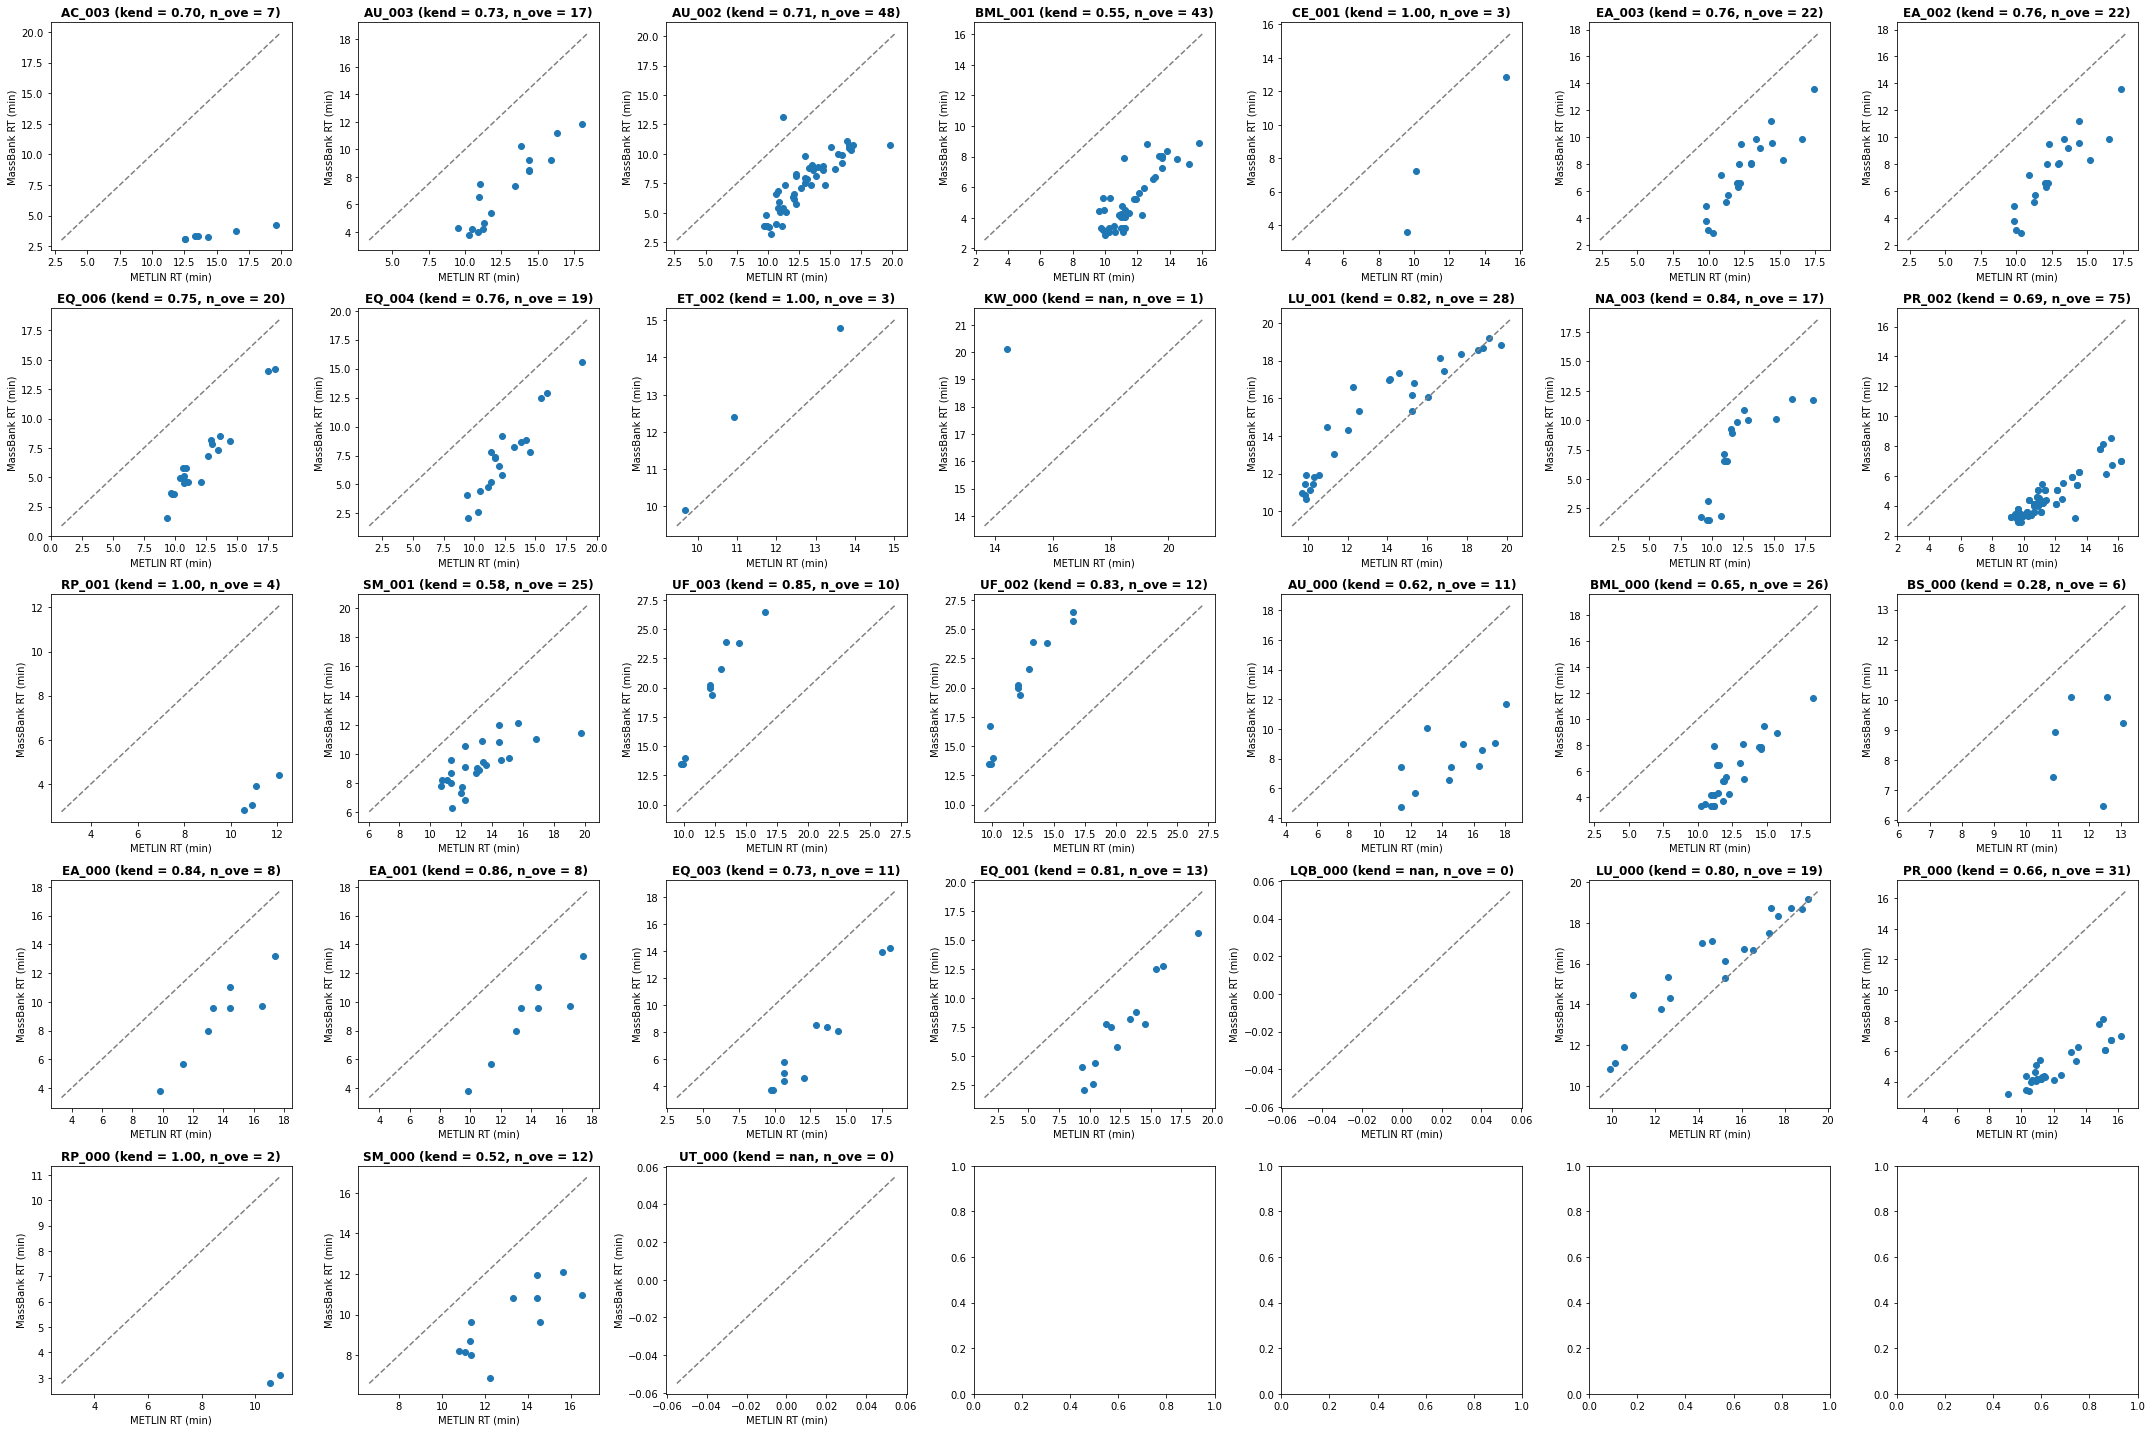

In [65]:
fig, axrr = plt.subplots(5, 7, figsize=(30, 20))

for i, row in df_overlap.iterrows():
    r, c = np.unravel_index(i, axrr.shape)
    
    axrr[r, c].scatter(row["metlin_rt"], row["massbank_rt"])
    axrr[r, c].set_title("%s (kend = %.2f, n_ove = %d)" % (row["dataset"], sp_stats.kendalltau(row["metlin_rt"], row["massbank_rt"])[0], row["n_overlap_with_metlin"]), fontweight="bold")
    axrr[r, c].set_xlabel("METLIN RT (min)")
    axrr[r, c].set_ylabel("MassBank RT (min)")
    _x_min, _x_max = axrr[r, c].get_xlim()
    _y_min, _y_max = axrr[r, c].get_ylim()
    axrr[r, c].plot(
        [np.minimum(_x_min, _y_min), np.maximum(_x_max, _y_max)], 
        [np.minimum(_x_min, _y_min), np.maximum(_x_max, _y_max)],
        linestyle="--", color="gray"
    )
    
plt.tight_layout()